In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from keras.models import Sequential
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_curve, average_precision_score,precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set memory growth to prevent TensorFlow from consuming all GPU memory at once
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


In [3]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dataset-for-classification-of-citrus-diseases/dataset/dataset/train',
    target_size=(250, 250),
    batch_size= 16,
    class_mode = 'categorical'
)
test_datagen = ImageDataGenerator(
    rescale = 1./225
)
test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/dataset-for-classification-of-citrus-diseases/dataset/dataset/test',
    target_size=(250, 250),
    batch_size=16,
    class_mode='categorical',
    shuffle=False 
)

Found 2032 images belonging to 2 classes.
Found 407 images belonging to 2 classes.


In [4]:
model = Sequential([
    layers.Conv2D(32,(2,2),activation="relu",input_shape=(250, 250,3),padding="valid"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), padding="valid"),
    
    layers.Conv2D(64,(2,2),activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128,(2,2),activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(256,(2,2),activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(512,(2,2),activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(1024,(2,2),activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),

    layers.Dense(1024,activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(2,activation="softmax")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 249, 249, 32)        │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 249, 249, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 123, 123, 64)        │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 123, 123, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 29, 29, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 29, 29, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 512)         │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 13, 13, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 5, 5, 1024)          │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 5, 5, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 7,663,074 (29.23 MB)

 Trainable params: 7,655,458 (29.20 MB)

 Non-trainable params: 7,616 (29.75 KB)

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("model_epoch_{epoch:02d}.keras",  # Save file as 'model_epoch_01.h5', 'model_epoch_02.h5', etc.
                             save_weights_only=False,  # Saves the entire model (architecture + weights)
                             save_freq='epoch',        # Save after every epoch
                             verbose=1)


In [7]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


127/127 ━━━━━━━━━━━━━━━━━━━━ 61s 356ms/step - accuracy: 0.6744 - loss: 0.8089 - val_accuracy: 0.4939 - val_loss: 0.7103
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 35s 264ms/step - accuracy: 0.7963 - loss: 0.4958 - val_accuracy: 0.5086 - val_loss: 0.9940
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 35s 265ms/step - accuracy: 0.7929 - loss: 0.4809 - val_accuracy: 0.6290 - val_loss: 0.7271
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 35s 262ms/step - accuracy: 0.8173 - loss: 0.4562 - val_accuracy: 0.8182 - val_loss: 0.4007
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 35s 259ms/step - accuracy: 0.8420 - loss: 0.3745 - val_accuracy: 0.7690 - val_loss: 0.4698
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 35s 263ms/step - accuracy: 0.8339 - loss: 0.4054 - val_accuracy: 0.8943 - val_loss: 0.2673
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 36s 267ms/step - accuracy: 0.8553 - loss: 0.3259 - val_accuracy: 0.8010 - val_loss: 0.5985
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 36s 266ms/step - accuracy: 0.8707 - loss: 0.3514 - val

127/127 ━━━━━━━━━━━━━━━━━━━━ 32s 253ms/step - accuracy: 0.8847 - loss: 0.2664
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9334 - loss: 0.1643
Train Accuracy: 0.8883
Validation Accuracy: 0.8943


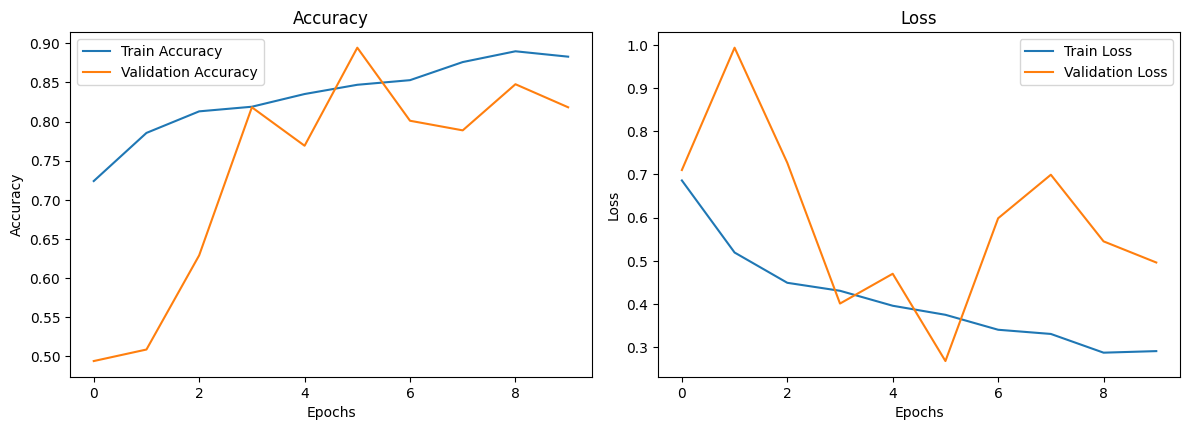

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step


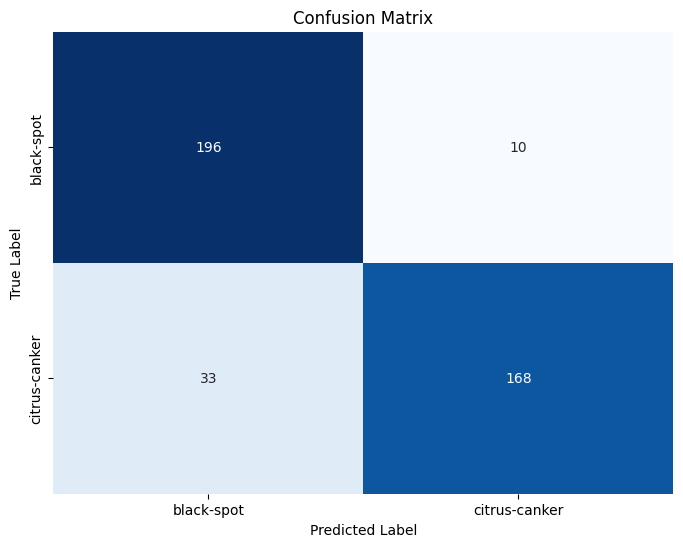

Classification Report:
               precision    recall  f1-score   support

   black-spot       0.86      0.95      0.90       206
citrus-canker       0.94      0.84      0.89       201

     accuracy                           0.89       407
    macro avg       0.90      0.89      0.89       407
 weighted avg       0.90      0.89      0.89       407



In [11]:
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(test_generator)
print(f'Train Accuracy: {train_acc:.4f}')
print(f'Validation Accuracy: {val_acc:.4f}')

# Save the model
model.save('citrus_disease_detection_v1.h5')

# Example usage of the prediction function
def predict_xray_image(model, img_path):
    img = image.load_img(img_path, target_size=(250, 250))  # Match size to model
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    prediction = model.predict(img_array)

    if prediction[0] > 0.5:
        result = 'Positive'
    else:
        result = 'Negative'

    plt.imshow(img)
    plt.title(f'Prediction: {result}')
    plt.show()

# Visualize metrics using Pandas and Matplotlib
history_df = pd.DataFrame(history.history)

# Plot multiple graphs (Accuracy and Loss)
plt.figure(figsize=(12, 8))

# Subplot for accuracy
plt.subplot(2, 2, 1)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(2, 2, 2)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Generate predictions for the test set
Y_pred = model.predict(test_generator)
Y_pred = np.argmax(Y_pred,axis=1)
Y_pred = (Y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, Y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(test_generator.classes, Y_pred, target_names=test_generator.class_indices.keys()))